<a href="https://colab.research.google.com/github/doukansurel/Image-Processing-with-Tensorflow/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

#Import Libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

#Load Data Set

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1G91S3/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1G91S3/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


#Setting Pixels in the Segmentation Mask

In [5]:
def normalize(input_image,input_mask):
  input_image=tf.cast(input_image,tf.float32)/255.0   #tf.cast bir tensor türünü yeni bir türe dönüştürmeye yarar.Buradaki işlem Normalizationdır. Görüntüleri işleyebileceğimiz değerlere dönüştürülür.
  input_mask -= 1
  return input_image,input_mask

In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint["image"],(128,128)) #yeniden boyutlandırma
  input_mask = tf.image.resize(datapoint["segmentation_mask"],(128,128))

  input_image,input_mask = normalize(input_image,input_mask)
  return input_image,input_mask

In [7]:
train_lenght = info.splits["train"].num_examples
batch_size = 64
buffer_size = 1000
steps_per_epoch = train_lenght//batch_size #adım başı epoch sayısı

#Data Set Preparing

In [8]:
train_images = dataset["train"].map(load_image,num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset["test"].map(load_image,num_parallel_calls = tf.data.AUTOTUNE)

#Augmented

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed = 42 ):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomFlip(mode ="horizontal",seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode = "horizontal",seed=seed)

  def call(self,inputs,labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs,labels

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(batch_size)


#Mask Visualization

In [11]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title = ["Input Image","True Mask","Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

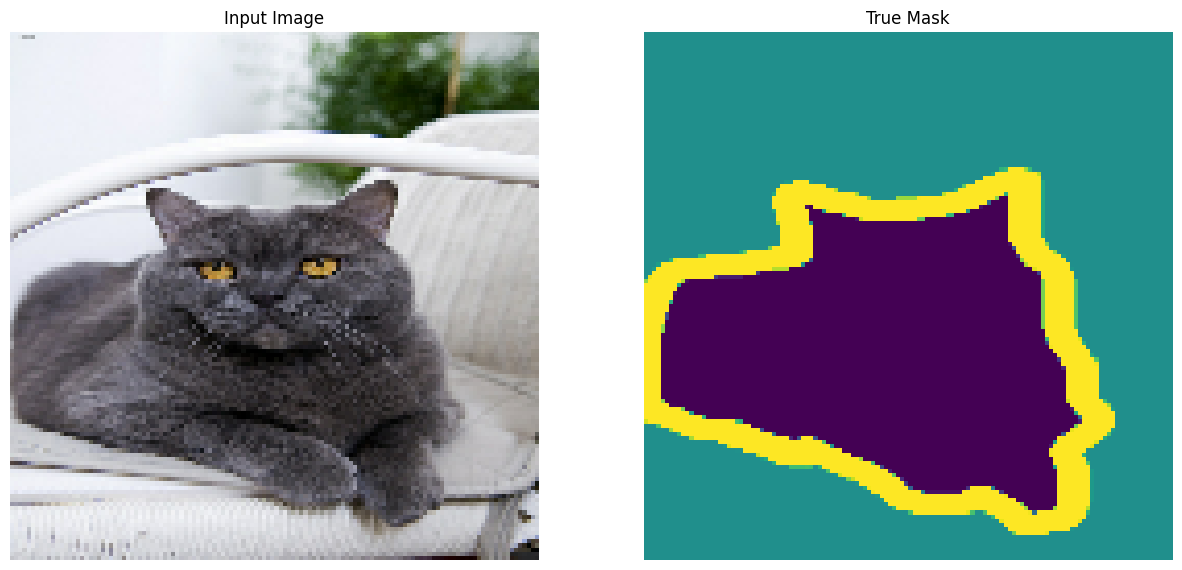

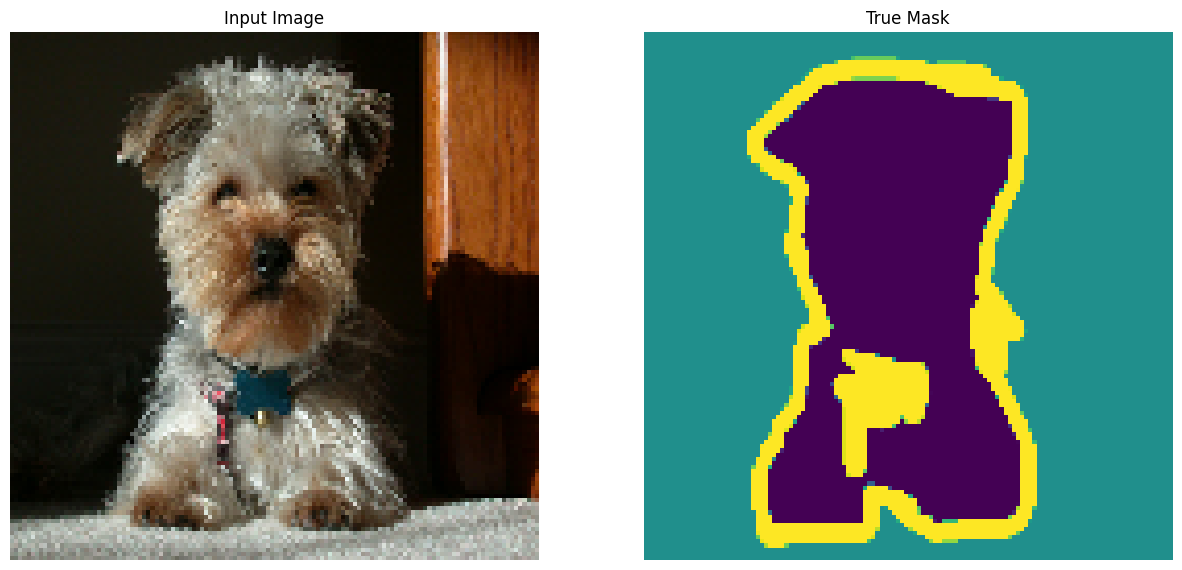

In [12]:
for images,masks in train_batches.take(2):
  sample_image,sample_mask = images[0], masks[0]
  display([sample_image,sample_mask])

#Model

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#Katmanlar
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#Model Training

In [16]:
output_classes = 3

model = unet_model(output_channels =output_classes)
model.compile(optimizer = "adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ["accuracy"]
              )

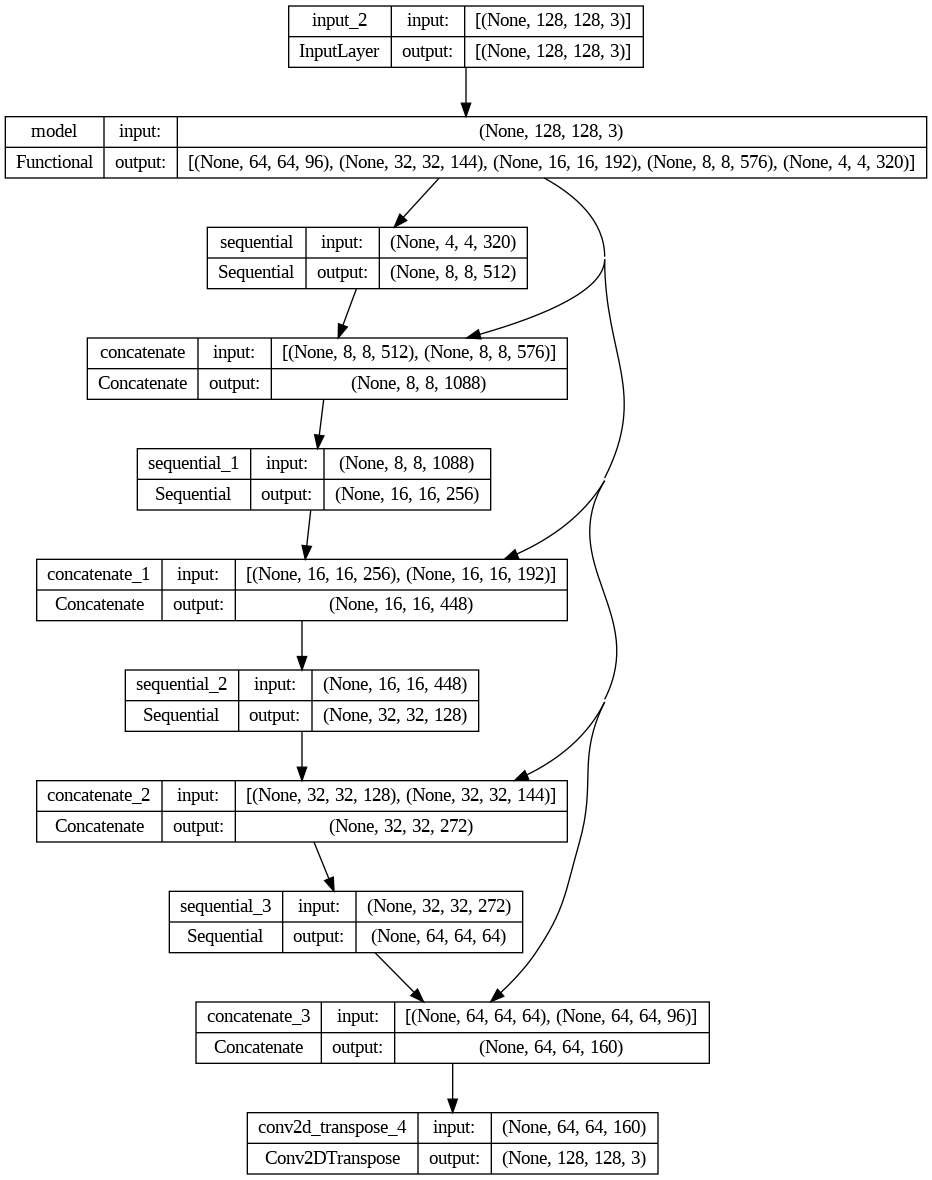

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask , axis = 1)
  pred_mask = pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset = None, num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0],mask[0],create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis,...]))
             ])

1/1 [==============================] - 9s 9s/step


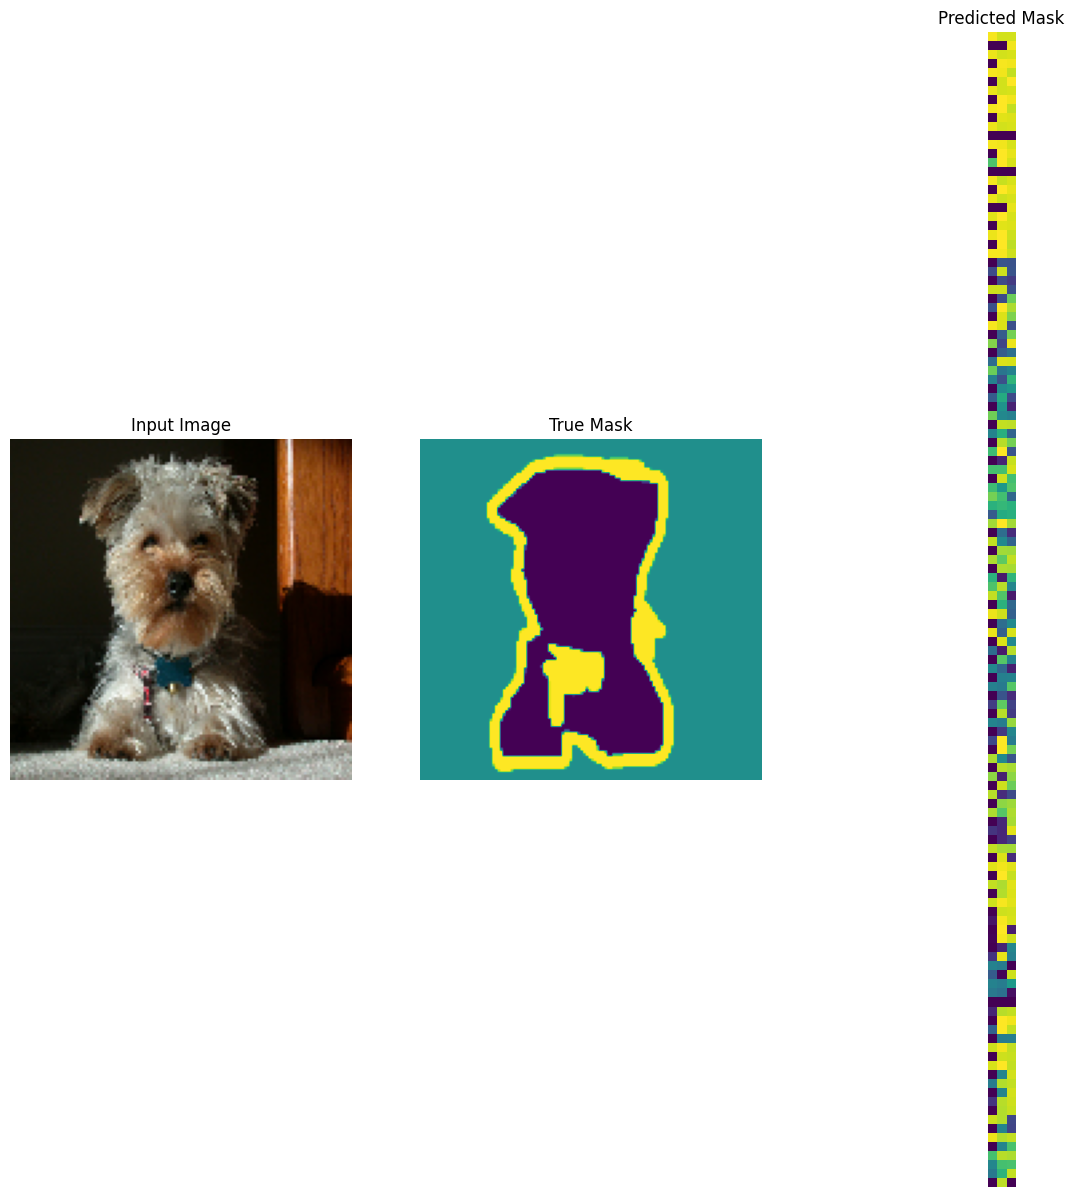

In [20]:
show_predictions()

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSample Prediction after epoch {} \n".format(epoch+1))

#Model Fit

1/1 [==============================] - 0s 22ms/step


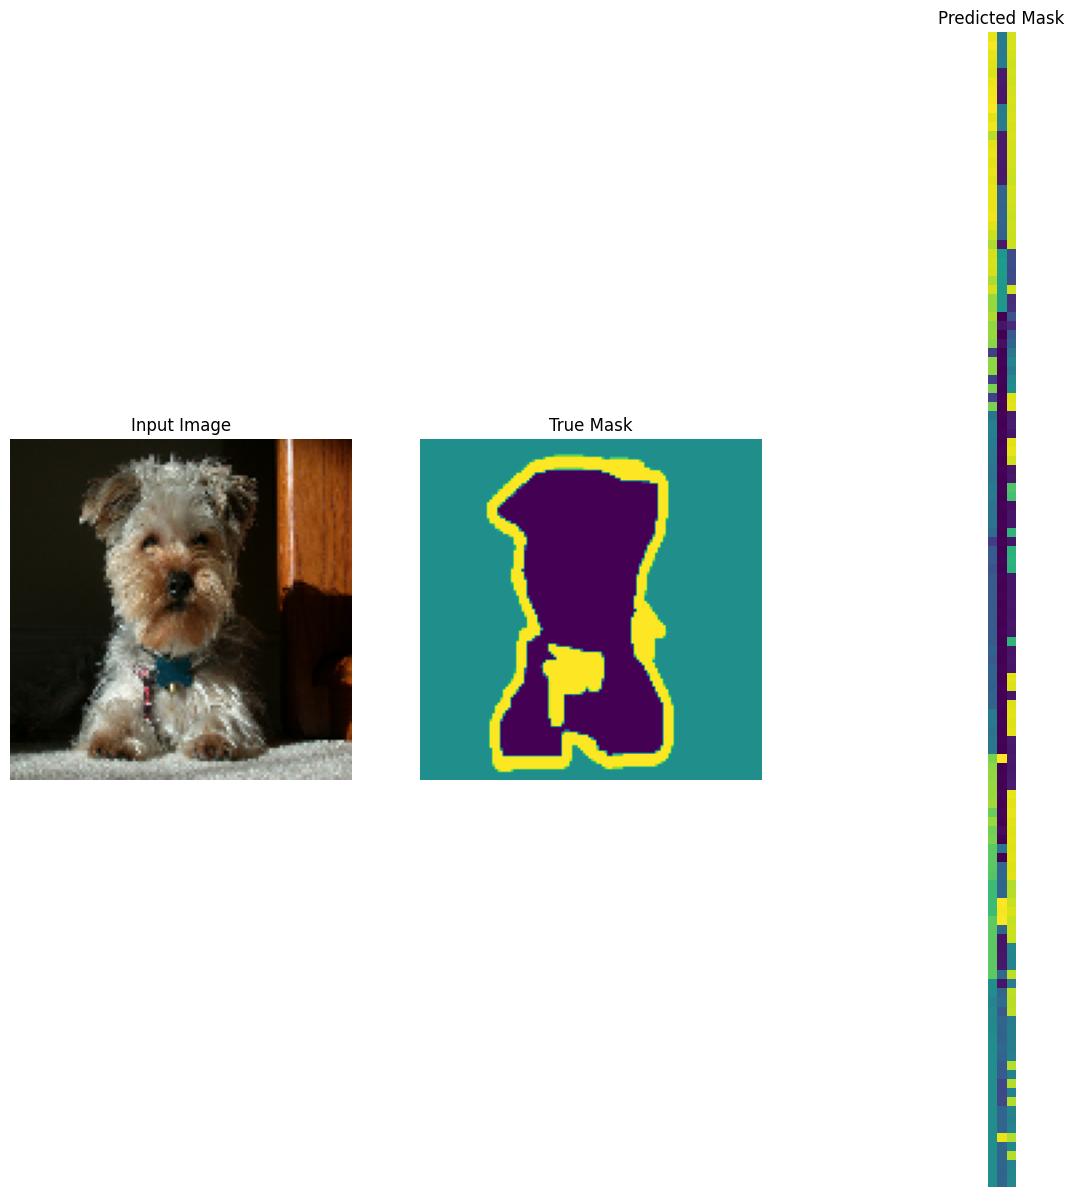


Sample Prediction after epoch 20 

57/57 [==============================] - 10s 173ms/step - loss: 0.1745 - accuracy: 0.9222 - val_loss: 0.2749 - val_accuracy: 0.8971


In [26]:
epochs = 20
val_subsplits = 5
validation_steps = info.splits["test"].num_examples//batch_size//val_subsplits

model_history = model.fit(train_batches,epochs = epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks = [DisplayCallback()])

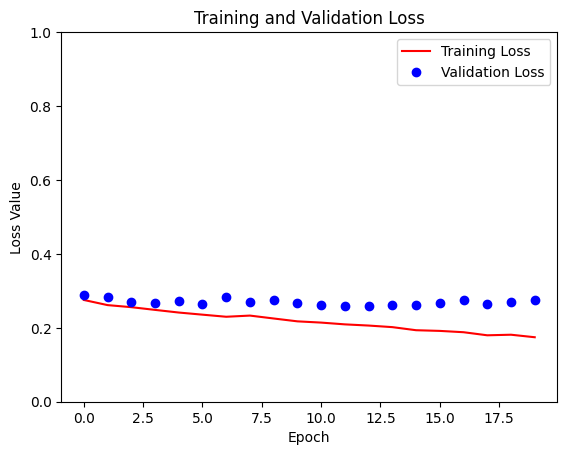

In [28]:
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

plt.figure()
plt.plot(model_history.epoch,loss,"r",label="Training Loss")
plt.plot(model_history.epoch,val_loss,"bo",label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0,1])
plt.legend()
plt.show()

#Predict

2/2 [==============================] - 0s 45ms/step


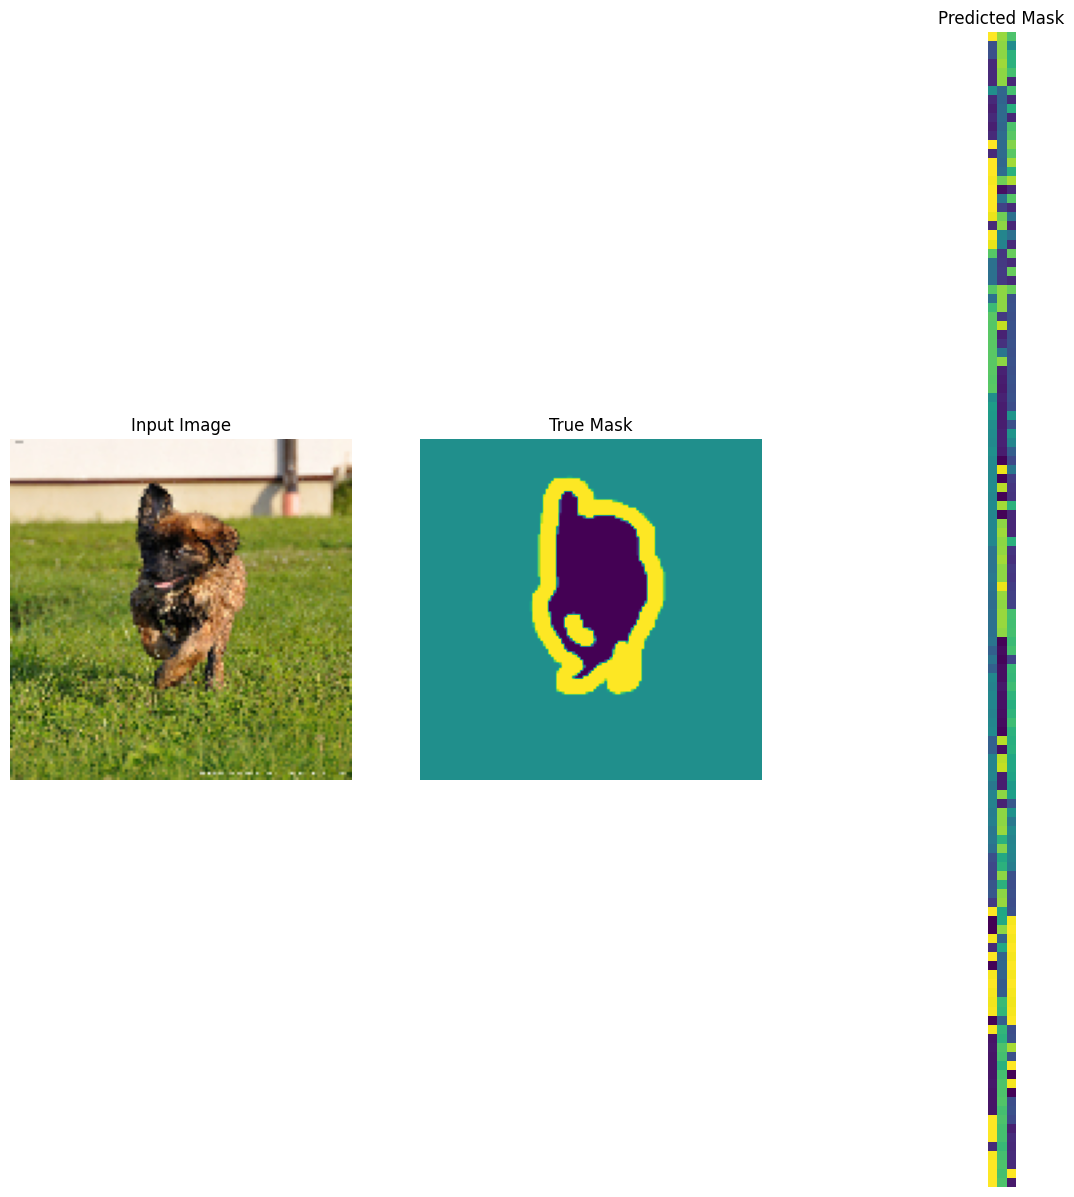

2/2 [==============================] - 0s 60ms/step


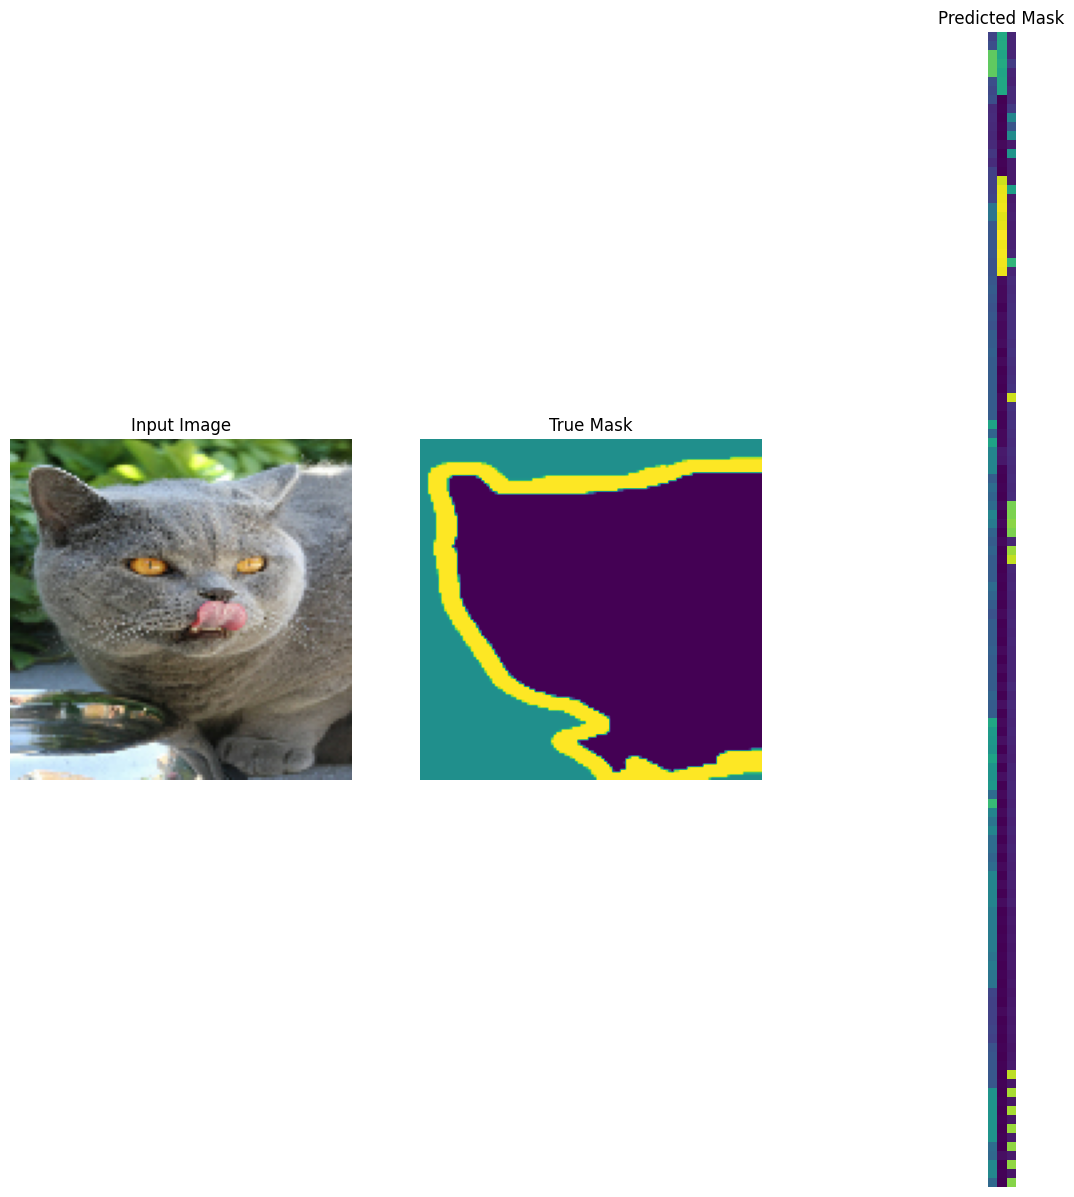

2/2 [==============================] - 0s 44ms/step


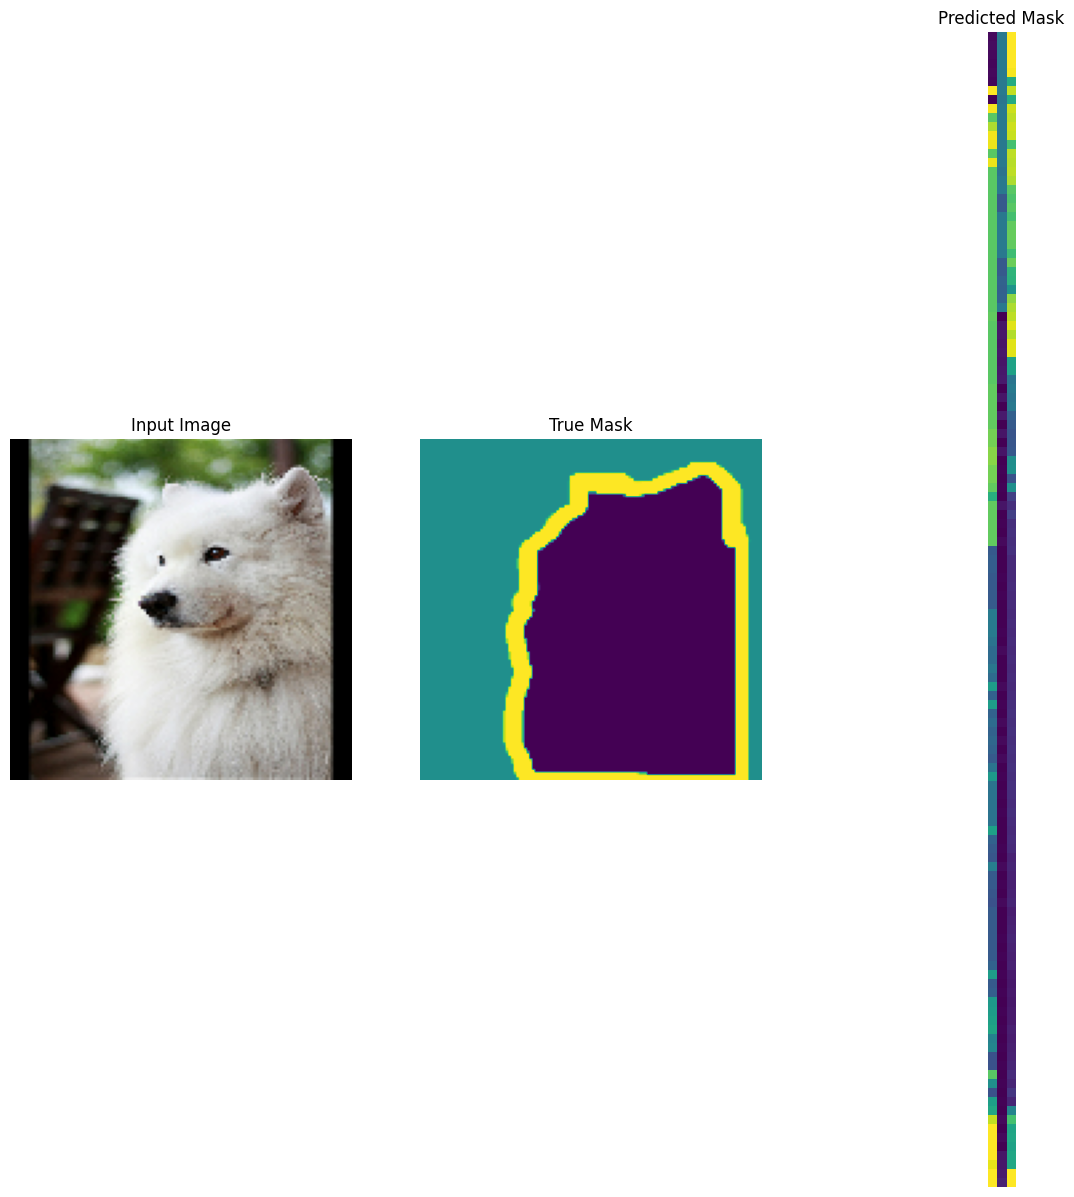

In [29]:
show_predictions(test_batches,3)